# Sprint15　CNN
### スクラッチでCNN (LeNet)を実装し、CIFER10画像認識タスクに適用する

In [1]:
import numpy as np
import gc
from keras.datasets import cifar10
image_num = 25000

(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = cifar10.load_data()

x_train_cifar10 = x_train_cifar10[:image_num]
y_train_cifar10 = y_train_cifar10[:image_num]
y_label_cifar10 = y_train_cifar10
y_train_cifar10 = np.identity(10)[y_train_cifar10]
del x_test_cifar10, y_test_cifar10

gc.collect()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


170500096/170498071 [==============================] - 36s 0us/step


6

In [2]:
x_train_cifar10.shape

(25000, 32, 32, 3)

### im2col col2im

In [3]:
def im2col(x, filter_size=4, stride=4, pad=0, padding='constant'):
    if pad > 0:
        x = np.pad(x, [(0, 0), (pad, pad), (pad, pad), (0, 0)], padding)
    N, H, W, C = x.shape
    return np.array([x[n, h:h + filter_size, w:w + filter_size, c].flatten() \
                     for c in range(C) \
                     for n in range(N) \
                     for h in range(0, H - filter_size + 1, stride) \
                     for w in range(0, W - filter_size + 1, stride)])


def im2col_v2(x, filter_size=4, stride=4, pad=0, padding='constant'):
    if pad > 0:
        x = np.pad(x, [(0, 0), (pad, pad), (pad, pad), (0, 0)], padding)
    data_size, height, width, channel = x.shape
    return np.array([x[n, h:h + filter_size, w:w + filter_size, :].flatten() \
                     for n in range(data_size) \
                     for h in range(0, height - filter_size + 1, stride) \
                     for w in range(0, width - filter_size + 1, stride)])


def im2col_v3(x, filter_size=4, stride=4, pad=0, padding='constant'):
    if pad > 0:
        x = np.pad(x, [(0, 0), (pad, pad), (pad, pad), (0, 0)], padding)
    data_size, height, width, channel = x.shape
    return np.array([x[:, h:h + filter_size, w:w + filter_size, c].flatten() \
                     for c in range(channel) \
                     for h in range(0, height - filter_size + 1, stride) \
                     for w in range(0, width - filter_size + 1, stride)])


def col2im_v2(x, input_shape, filter_size=4, stride=4, pad=0, padding='constant'):
    #_, out_H, out_W, _ = x.shape
    in_N, in_H, in_W, in_C = input_shape
    out_H = 1 + int((in_H + 2 * pad - filter_size) / stride)
    out_W = 1 + int((in_W + 2 * pad - filter_size) / stride)
    img = np.zeros((in_N, in_H + 2*pad, in_W + 2*pad, in_C))
    for i, line in enumerate(x):
        data_i, square_i = divmod(i, out_H*out_W)
        height_i, width_i = divmod(square_i, out_H)
        img[data_i, height_i: height_i+filter_size, width_i:width_i + filter_size, :] =\
        line.reshape(filter_size, filter_size, in_C)
    return img[:, pad:pad + in_H, pad:pad + in_W, :]


def col2im_v3(x, input_shape, filter_size=4, stride=4, pad=0, padding='constant'):
    #_, out_H, out_W, _ = x.shape
    in_N, in_H, in_W, in_C = input_shape
    out_H = 1 + int((in_H + 2 * pad - filter_size) / stride)
    out_W = 1 + int((in_W + 2 * pad - filter_size) / stride)
    img = np.zeros((in_N, in_H + 2*pad, in_W + 2*pad, in_C))
    for i, line in enumerate(x):
        channel_i, data_i = divmod(i, in_N*out_H* out_W)
        data_i, square_i = divmod(data_i, out_H*out_W)
        height_i, width_i = divmod(square_i, out_H)
        height_i *= stride
        width_i *= stride
        img[data_i, height_i: height_i+filter_size, width_i:width_i + filter_size, channel_i] =\
        line.reshape(filter_size, filter_size)
    return img[:, pad:pad + in_H, pad:pad + in_W, :]


def col2im(x, input_shape, filter_size=4, stride=4, pad=0, padding='constant'):
    # 戻すデータの形状
    N, H, W, C = input_shape
    img = np.zeros((N, H + 2*pad, W + 2*pad, C))
    block_num = (pad * 2 + W - filter_size) // stride + 1  
    # １チャネルに何行あるか
    c_vol = int(x.shape[0] / C)
    n_vol = int(c_vol / N)

    for i, line in enumerate(x):
        block = line.reshape(filter_size, filter_size)
        channel_i = i // c_vol
        data_i = i % c_vol // n_vol
        start_h, start_w = divmod(i % n_vol, block_num)
        start_h, start_w = int(start_h), int(start_w)
        end_h = start_h + filter_size
        end_w = start_w + filter_size

        try:
            img[data_i, start_h:end_h, start_w:end_w, channel_i] = block
        except:
            print("N {} H {} W {} C {} ".format(data_i, start_h, start_w, channel_i))
            print(block.shape)
            print("img shape {}".format(img.shape))
            print(img[data_i, start_h:end_h, start_w:end_w, channel_i].shape)
            print('i {} c_vol {} n_vol {} block_num {}'.format(i, c_vol, n_vol, block_num))
            raise

    return img[:, pad:pad + H, pad:pad + W, :]

### 単層クラス

In [4]:
class Layer:
    def __init__(self, params={}):
        if 'input_shape' in params:
            self.in_shape = params['input_shape']
        else:
            self.in_shape = None

        if 'output_shape' in params:
            self.out_shape = params['output_shape']
        else:
            self.out_shape = None

            
class MaxPooling(Layer):
    def __init__(self, pool_size=4, stride=-1, pad=0, params={}):
        super(MaxPooling, self).__init__(params)
        self.pool_size = pool_size
        self.stride = stride
        self.pad = pad
        self.stride = self.pool_size if self.stride == -1 else stride
        self.max_index = None
        self.input_shape = None 

        
    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        N, H, W, C = in_shape
        out_h = 1 + int((H + 2 * self.pad - self.pool_size) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - self.pool_size) / self.stride)
        self.out_shape = (N, out_h, out_w, C)
        print("Pooling : out {} filter {} stride {} pad {} ".format(self.out_shape, \
                                                                    self.pool_size, \
                                                                    self.stride,\
                                                                    self.pad))
        return self.out_shape
    
    
    def forward(self, x):
        self.input_shape = x.shape
        N, H, W, C = x.shape
        out_h = 1 + int((H + 2 * self.pad - self.pool_size) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - self.pool_size) / self.stride)
        col = im2col(x, self.pool_size, self.stride, self.pad)
        col_max = np.max(col, axis=1)
        self.max_index = np.argmax(col, axis=1)
        return col_max.reshape(C, N, out_h, out_w).transpose(1, 2, 3, 0)

    
    def backward(self, dout):
        filter_size = dout.shape[1]
        N, out_h, out_w, _ = self.out_shape
        dout_line = dout.transpose(3, 0, 1, 2).reshape(-1)
        dout = np.zeros([dout_line.shape[0], self.pool_size * self.pool_size])
        for i, max_i in enumerate(self.max_index):
            dout[i, max_i] = dout_line[i]
        return col2im_v3(dout, self.input_shape, self.pool_size, self.stride, self.pad)


class Convolution(Layer):
    def __init__(self, out_channel=1, filter_size=3, stride=1, pad=0, bias=True, params={}):
        #self.out_channel = out_channel
        self.filnum = out_channel
        self.out_channel = out_channel
        self.filter_size = filter_size
        self.filsize = filter_size
        self.stride = stride
        self.pad = pad
        self.bias = bias
        self.W = None
        self.b = None
        self.x = None
        self.padding = 'constant'
        self.dW = None
        self.db = None
        self.optimize = None
        if 'lr' in params:
            self.lr = params['lr']
        else:
            self.lr = 0.01
        self.x_2dim = None

        
    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape  
        N, H, W, in_channel = in_shape
        out_h = 1 + int((H + 2 * self.pad - self.filter_size) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - self.filter_size) / self.stride)
        self.out_shape = (N, out_h, out_w, self.out_channel)
        # 重みの初期化
        ww = np.random.randn(self.filter_size * self.filter_size * in_channel, self.out_channel)
        self.W2 = ww * 0.01
        self.W = ww.reshape(self.filnum, self.filsize, self.filsize, in_channel,order='F').transpose(0,2,1,3)
        self.b = np.random.randn(1, self.filnum)
        self.db = np.zeros((1, self.filnum))
        
        if 'optimizer' in params:
            if params['optimizer'] == 'sgd':
                self.optimize = self.update_sgd
            elif params['optimizer'] == 'adagrad':
                self.h = np.zeros_like(W)
                self.optimize = self.update_adagrad
            else:  # params['optimizer'] == 'adam':
                self.m = np.zeros_like(self.W)
                self.v = np.zeros_like(self.W)
                self.beta1 = 0.9
                self.beta2 = 0.999
                self.optimize = self.update_adam
        else:
            self.optimize = self.update_sgd
            
        print("Convolution : out {}, filter {}, stride {} ".format(self.out_shape, self.filter_size,\
                                                                   self.stride))
        
        return self.out_shape


    def forward(self, x):
        if self.pad > 0:
            x1 = np.pad(x, [(0, 0), (self.pad, self.pad), (self.pad, self.pad), (0, 0)], self.padding)
        self.x = x1
        v_num = 1 + ((self.x.shape[1] - self.filsize) // self.stride)
        h_num = 1 + ((self.x.shape[2] - self.filsize) // self.stride) 
        self.h_num = h_num    
        W_matrix = np.zeros((self.W.shape[0], self.W.shape[1] * self.W.shape[2] * self.W.shape[3]))
        X_matrix = np.zeros((self.W.shape[1] * self.W.shape[2] * self.W.shape[3],\
                             v_num * h_num * self.x.shape[0]))
        for c in range(self.W.shape[3]):
            filtersize = self.W.shape[1] * self.W.shape[2]
            head = c * filtersize
            bottom = head + filtersize
            for f in range(self.W.shape[0]):          
                W_matrix[f,head:bottom] = self.W[f, :, :, c].reshape(1,-1)
            for p in range(self.x.shape[0]):
                col = p * v_num * h_num
                start = c * filtersize
                end = start + filtersize
                for v in range(v_num):
                    v1 = v * self.stride
                    v2 = v1 + self.filsize
                    for h in range(h_num):
                        h1 = h * self.stride 
                        h2 = h1 + self.filsize 
                        X_matrix[start:end,col:col+1] = self.x[p, v1:v2, h1:h2, c].reshape(-1,1)
                        col +=1         
        channel_result = np.dot(W_matrix, X_matrix) + self.b.T
        channel_result = channel_result.transpose(1,0).reshape(self.x.shape[0], h_num, v_num, self.filnum)
        self.X_matrix = X_matrix      
        N, _, _, _ = x.shape
        _, out_h, out_w, _ = self.out_shape
        x_2dim = im2col_v2(x, self.filter_size, self.stride, self.pad)
        out = np.dot(x_2dim, self.W2) + self.b
        # 整形する　out_C, W * H *N -> N H W out_C
        out = out.reshape(N, out_h, out_w, -1)
        self.x_2dim = x_2dim    
        return channel_result 


    def backward(self, dout):
        Wmatrix = np.zeros((self.filnum * dout.shape[1]**2, self.x.shape[3] * self.x.shape[1]**2))
        dout_size = dout.shape[1]*dout.shape[2]
        for c in range(self.x.shape[3]):
            for f in range(self.filnum):
                gap = self.x.shape[1] - self.filsize
                content = np.zeros((1, self.filsize**2 + gap * (self.filsize-1)))
                for i in range(self.filsize):
                    start = i * (self.filsize + gap)
                    content[0, start:start+self.filsize] = self.W[f,i,:,c]   
                head = c * self.x.shape[1]**2
                for row in range(dout_size):
                    head += self.stride
                    if (row % self.h_num) == 0:
                        head = self.x.shape[1] * self.stride * (row // self.h_num) + c * self.x.shape[1]**2
                    Wmatrix[f*dout_size+row, head:head+content.shape[1]] = content
                     
        dout2 = dout.transpose(0,3,1,2).reshape(self.x.shape[0], self.filnum * dout.shape[1]**2) 
        dx0 = np.dot(dout2, Wmatrix)  
        dx = dx0.reshape(self.x.shape[0], self.x.shape[1], self.x.shape[2], self.x.shape[3],order='F')\
             .transpose(0,2,1,3)
        dout2 = dout.reshape(dout.shape[0] * dout.shape[1] * dout.shape[2], self.filnum)
        dW = np.dot(self.X_matrix, dout2)
        self.dW = dW.transpose(1,0).reshape(self.filnum, self.filsize, self.filsize, self.x.shape[3])
        for f in range(self.filnum):
            self.db[0,f] = np.sum(dout[:,:,:,f])   
        dout99 = dout.reshape(-1, self.out_channel)
        db99 = np.sum(dout99, axis=0, keepdims=True)
        dW99 = np.dot(self.x_2dim.T, dout99)
        dx99 = np.dot(dout99, self.W2.T)
        dx99 = col2im_v2(dx99, self.in_shape, self.filter_size, self.stride, self.pad)
        a111 = dx[:,self.pad:self.pad+self.in_shape[1],self.pad:self.pad+self.in_shape[2],:]
        return dx[:,self.pad:self.pad+self.in_shape[1],self.pad:self.pad+self.in_shape[2],:]

    
    def update_sgd(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db

    def update_adagrad(self, lr=0.01):
        self.h += self.dW ** 2
        self.W -= self.lr * self.dW / (np.sqrt(self.h) + 1e-7)
        self.b -= self.lr * self.db

    def update_adam(self, lr=0.01):
        self.m = self.beta1 * self.m + (1 - self.beta1) * self.dW
        self.v = self.beta2 * self.v + (1 - self.beta2) * (self.dW * self.dW)
        m_hat = self.m / (1 - self.beta1)
        v_hat = self.v / (1 - self.beta2)
        self.W -= self.lr * m_hat / (np.sqrt(v_hat) + 1e-8)
        self.b -= self.lr * self.db


class Flatten(Layer):
    # (N, H, W, C)　→　(N, H * W * C)　　変換
    def __init__(self, params={}):
        super(Flatten, self).__init__(params)

    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        N, H, W, C = in_shape
        self.out_shape = (N, H * W * C)
        print("Flatten : out {} ".format(self.out_shape))
        return self.out_shape

    def forward(self, x):
        self.input_shape = x.shape
        out = np.array([elem.flatten() for elem in x])
        return out

    def backward(self, dout):
        dout = dout.reshape(self.input_shape)
        return dout


class Dropout(Layer):
    def __init__(self, params):
        super(Dropout, self).__init__(params)
        if 'dropout_ratio' in params:
            self.dropout_ratio = params['dropout_ratio']
        else:
            self.dropout_ratio = 0.5
        self.mask = None

    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        self.out_shape = self.in_shape
        print("Dropout : ratio {}  ".format(self.dropout_ratio))
        return self.out_shape

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.random_sample(x.shape) > self.dropout_ratio 
            return x * self.mask
        else:
            return x * (1 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNorm(Layer):
    def __init__(self, params):
        super(BatchNorm, self).__init__(params)
        self.out = None
        self.beta = 0.0
        self.gamma = 1.0
        self.lr = params['lr']
        self.eps = 1e-8


    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        self.out_shape = self.in_shape
        print("BatchNorm : out {} lr {}  ".format(self.out_shape, self.lr))
        return self.out_shape

    def forward(self, x):
        # step1: 平均を求める
        mu = np.mean(x, axis=0)

        # step2: 偏差
        self.xmu = x - mu

        # step3 : 偏差の２乗
        sq = self.xmu ** 2

        # step4 : 分散を求める
        self.var = np.var(x, axis=0)

        # step5 : 分散のルートを取った値を求める
        self.sqrtvar = np.sqrt(self.var + self.eps)

        # step6 : sqrtvarの逆数（invert）
        self.ivar = 1.0 / self.sqrtvar

        # step7 : 標準化した値
        self.xhat = self.xmu * self.ivar

        # step8
        gammax = self.gamma * self.xhat

        # step9
        out = gammax + self.beta

        return out

    
    def backward(self, dout=1):
        N, D = dout.shape
        
        # step9
        self.d_beta = np.sum(dout, axis=0)
        dgammax = dout  

        # step8
        self.d_gamma = np.sum(dgammax * self.xhat, axis=0)
        dxhat = dgammax * self.gamma

        # step7
        divar = np.sum(dxhat * self.xmu, axis=0)
        dxmu1 = dxhat * self.ivar

        # step6
        dsqrtvar = -1. / (self.sqrtvar ** 2) * divar

        # step5
        dvar = 0.5 * 1. / np.sqrt(self.var + self.eps) * dsqrtvar

        # step4
        dsq = 1. / N * np.ones((N, D)) * dvar

        # step3
        dxmu2 = 2 * self.xmu * dsq

        # step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1 + dxmu2, axis=0)

        # step1
        dx2 = 1. / N * np.ones((N, D)) * dmu

        # step0
        dx = dx1 + dx2

        return dx

    
    def optimize(self):
        self.gamma -= self.lr * self.d_gamma
        self.beta -= self.lr * self.d_beta


class Activation(Layer):
    def __init__(self, params):
        super(Activation, self).__init__(params)
        self.out = None
        self.mask = None
        if 'activation' in params:
            if params['activation'] == 'tanh':
                self.forward = self.forward_tanh
                self.backward = self.backward_tanh
            elif params['activation'] == 'sigmoid':
                self.forward = self.forward_sigmoid
                self.backward = self.backward_sigmoid
            else:  # params['activation'] == 'relu':
                self.forward = self.forward_relu
                self.backward = self.backward_relu
        else:
            params['activation'] = 'relu'
            self.forward = self.forward_relu
            self.backward = self.backward_relu

    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        self.out_shape = self.in_shape
        print("Activation : out {}   func : {} ".format(self.out_shape, params['activation']))
        return self.out_shape

    
    # ReLu
    def forward_relu(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    
    def backward_relu(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

    
    # tanh
    def forward_tanh(self, x):
        out = np.tanh(x)
        self.out = out
        return out

    
    def backward_tanh(self, dout):
        dx = dout * (1 - np.tanh(dout) ** 2)
        return dx

    
    # sigmoid関数
    def forward_sigmoid(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    
    def backward_sigmoid(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class Affine(Layer):
    def __init__(self, unit_size=100, params={}):
        super(Affine, self).__init__(params)
        self.W = None
        self.b = None
        self.x = None
        self.unit_size = unit_size
        self.dW = None
        self.db = None
        if 'lr' in params:
            self.lr = params['lr']
        else:
            self.lr = 0.01

    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        N, F = in_shape
        self.out_shape = (N, self.unit_size)

        # 重みの初期化
        self.W = np.random.randn(F, self.unit_size)
        self.b = np.zeros([1, self.unit_size])
        self.W *= 0.01

        # オプティマイザの設定
        if 'optimizer' in params:
            if params['optimizer'] == 'sgd':
                self.optimize = self.update_sgd
            elif params['optimizer'] == 'adagrad':
                self.h = np.zeros_like(self.W)
                self.optimize = self.update_adagrad
            else:  # params['optimizer'] == 'adam':
                self.m = np.zeros_like(self.W)
                self.v = np.zeros_like(self.W)
                self.beta1 = 0.9
                self.beta2 = 0.999
                self.optimize = self.update_adam
        else:
            params['optimizer'] = 'adam'
            self.optimize = self.update_adam
        print("Affine : out {} optimizer {} unit {} ".format(self.out_shape, params['optimizer'],\
                                                             self.unit_size))
        return self.out_shape

    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    
    def backward(self, dout=1):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

    
    def update_sgd(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db

        
    def update_adagrad(self, lr=0.01):
        self.h += self.dW ** 2
        self.W -= self.lr * self.dW / (np.sqrt(self.h) + 1e-7)
        self.b -= self.lr * self.db

        
    def update_adam(self, lr=0.01):
        self.m = self.beta1 * self.m + (1 - self.beta1) * self.dW
        self.v = self.beta2 * self.v + (1 - self.beta2) * (self.dW * self.dW)
        m_hat = self.m / (1 - self.beta1)
        v_hat = self.v / (1 - self.beta2)
        self.W -= self.lr * m_hat / (np.sqrt(v_hat) + 1e-8)
        self.b -= self.lr * self.db


class SoftmaxWithLoss(Layer):
    def __init__(self, params={}):
        super(SoftmaxWithLoss, self).__init__(params)
        self.loss = None  # 損失関数
        self.y = None  # softmaxの出力
        self.t = None  # 教師データ（one-hot vector)

        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size  # delta3に相当
        return dx


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


def cross_entropy_error(y, y_pred):
    data_size = y.shape[0]
    cross_entorpy = -np.sum(y * np.log(y_pred + 1e-7))
    error = cross_entorpy / data_size
    return error

### layersクラス

In [5]:
from collections import OrderedDict
import numpy as np
import time

class LeNetLayers:
    def __init__(self, params):
        unit_size_list = [params['input_size']]
        unit_size_list.extend(params['hidden_layer_list'])
        unit_size_list.append(params['output_size'])

        self.params = {}

        # レイヤの生成
        self.layers = OrderedDict()

        self.layers['Conv1'] = Convolution(6, 5, 1, 2)  # 2 (3,3) (1,1) same
        self.layers['Active1'] = Activation(params)  # relu
        self.layers['Pool1'] = MaxPooling(2, 2, 0, params)
        self.layers['Conv2'] = Convolution(16, 5, 1, 2)  # 2 (3,3) (1,1) same
        self.layers['Active2'] = Activation(params)  # relu
        self.layers['Pool2'] = MaxPooling(2, 2, 0, params)
        self.layers['Flatten'] = Flatten(params)
        self.layers['Affine1'] = Affine(120, params)
        self.layers['BatchNorm1'] = BatchNorm(params)
        self.layers['Active3'] = Activation(params)  # relu
        self.layers['Affine2'] = Affine(84, params)
        self.layers['BatchNorm2'] = BatchNorm(params)
        self.layers['Active4'] = Activation(params)  # relu
        self.layers['Affine3'] = Affine(params['output_size'], params)

    def initialize(self, x, y, params):
        in_shape = x.shape 
        print(x.shape)
        out_shape = y.shape 
        print('###########' * 5)
        for i, layer_ in enumerate(self.layers.values()):
            print(" Layer {}".format(i))
            in_shape = layer_.initialize(in_shape, params)
            print('###########' * 5)

        self.lastLayer = SoftmaxWithLoss()


    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    
    def accuracy(self, x, t):
        y_pred = self.predict(x)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(t, axis=1)
        data_size = x.shape[0]
        correct_count = np.sum([y_true == y_pred])
        score = correct_count / data_size * 100
        return round(score, 2)

    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    
    def optimize(self, x, t):
        # forward
        self.loss(x, t)   
        # backward
        dout = self.lastLayer.backward(1)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)    
        for layer in self.layers.values():         
            if hasattr(layer, "optimize"):
                layer.optimize()

In [6]:
import numpy as np
import random
from sklearn.model_selection import train_test_split


class CNN:
    def __init__(self, init='gauss', epochs=10, lr=0.05, lam=0.01,
                 batch_mode='batch', activation='relu',
                 batch_size_rate=0.0016, hidden_layer_list=[5], optimizer='sgd',
                 batch_norm=False, dropout_ratio=0.0):
        """ ハイパーパラメータ解説
        init: 初期化方法
            'he' :
            'gauss'
            'xavier'
        lr : 学習率
        lam : 正則化項の率
        batch_size: バッチサイズ
            'batch' : フルサイズ
            'mini' 0< x< 1: フルサイズ割合 0.1なら全体の0.1サイズ使用する
            'online' : オンライン学習　１データのみ
        hidden_layer_list : 隠れ層のリスト、層のユニットをリストで入力　例[2, 3]　ユニット数２、\
　　　　　　　　　　　　　　ユニット数３の隠れ層
        optimizer : 勾配の更新手法
            'sgd' 
            'adam'
            'adagrad'
        activation: 活性化関数の種類
            'relu' 
            'tanh' 
            'sigmoid'
        """
        self.params = {}
        self.params['epochs'] = epochs
        self.params['init'] = init
        self.params['lr'] = lr
        self.params['lam'] = lam  
        self.params['batch_mode'] = batch_mode  
        self.params['batch_size_rate'] = batch_size_rate  
        self.params['hidden_layer_list'] = hidden_layer_list
        self.params['optimizer'] = optimizer
        self.params['batch_norm'] = batch_norm
        self.params['dropout_ratio'] = dropout_ratio
        self.params['activation'] = activation

    def train(self, X, y, params={}):
        # 入力パラメータがあれば更新する
        for key in params:
            self.params[key] = params[key]

        X = X / 255.0

        # 訓練とテストデータに分割
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.2, random_state=0)

        self.params['data_size'] = X_train.shape[0]
        self.params['input_size'] = X_train.shape[1]
        self.params['output_size'] = y_train.shape[1]

        # コストや正答率の学習曲線を引くためのリストを用意
        past_train_costs = []
        past_test_costs = []
        past_train_accuracy = []
        past_test_accuracy = []

        N, H, W, C = X_train.shape

        # バッチサイズの設定
        if self.params['batch_mode'] == 'batch':
            self.params['batch_size'] = self.params['data_size']
        elif self.params['batch_mode'] == 'mini':
            self.params['batch_size'] = int(self.params['data_size'] * self.params['batch_size_rate'])
        else:
            self.params['batch_size'] = 1
        # 隠れ層やレイヤーインスタンス生成
        # 入力サイズをバッチ分に調整
        in_shape = (self.params['batch_size'], H, W, C)
        self.params['layer'] = LeNetLayers(self.params)
        # 入出力サイズ
        self.params['layer'].initialize(X_train[:self.params['batch_size']],\
                                        y_train[:self.params['batch_size']],\
                                        self.params)

        iteration = int(X_train.shape[0] / self.params['batch_size'])
        choice_list = list(range(X_train.shape[0]))
        
        for i in range(self.params['epochs']*iteration):
            time10 = time.time()
            start = i % iteration * self.params['batch_size']
            end = start + self.params['batch_size']
            X_batch, y_batch = X_train[choice_list[start:end]], y_train[choice_list[start:end]]

            # 誤差逆伝播法によって勾配を求め、値を更新  
            self.params['layer'].optimize(X_batch, y_batch)
            time111 = time.time()
            # 1エポックごとに正答率とコストを算出して保存する
            if i==0 or (i%iteration is 0):
                train_acc = self.params['layer'].accuracy(X_train, y_train)
                past_train_accuracy.append(train_acc)
                test_acc = self.params['layer'].accuracy(X_test, y_test)
                past_test_accuracy.append(test_acc)
                train_loss = self.params['layer'].loss(X_train, y_train)
                past_train_costs.append(train_loss)
                test_loss = self.params['layer'].loss(X_test, y_test)
                past_test_costs.append(test_loss)
                print("epoch:{} train_acc:{}, train_loss:{}, test_acc:{}, test_loss:{}"\
                      .format(i//iteration, train_acc, train_loss, test_acc, test_loss))
            if i%iteration is 9:
                random.shuffle(choice_list)
        return past_train_accuracy, past_test_accuracy, past_train_costs, past_test_costs


    def predict(self, X, probability=False):
        predict = self.params['layer'].predict(X, train_flg=False)
        predict_proba = softmax(predict)
        if probability is True:
            return predict_proba
        else:
            return np.argmax(predict_proba, axis=1)

### モデル学習

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


(32, 32, 32, 3)
#######################################################
 Layer 0
Convolution : out (32, 32, 32, 6), filter 5, stride 1 
#######################################################
 Layer 1
Activation : out (32, 32, 32, 6)   func : relu 
#######################################################
 Layer 2
Pooling : out (32, 16, 16, 6) filter 2 stride 2 pad 0 
#######################################################
 Layer 3
Convolution : out (32, 16, 16, 16), filter 5, stride 1 
#######################################################
 Layer 4
Activation : out (32, 16, 16, 16)   func : relu 
#######################################################
 Layer 5
Pooling : out (32, 8, 8, 16) filter 2 stride 2 pad 0 
#######################################################
 Layer 6
Flatten : out (32, 1024) 
#######################################################
 Layer 7
Affine : out (32, 120) optimizer adam unit 120 
#######################################################
 Layer 8
BatchNor

Text(0.5,0,'iteration[epoch]')

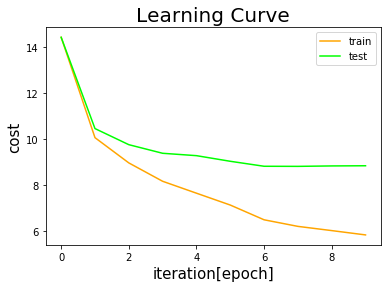

In [7]:
import matplotlib.pyplot as plt
% matplotlib inline

model = CNN(epochs=10, optimizer='adam',batch_norm=True)

params = {'batch_mode' : 'mini',
          'lr': 0.01}

past_train_accuracy, past_test_accuracy, past_train_costs, past_test_costs = model.train(x_train_cifar10,\
                                                                                         y_train_cifar10.\
                                                                                         reshape(image_num, 10),\
                                                                                         params)

plt.figure(figsize=(6,4))
plt.plot(past_train_costs, color='orange', label='train')
plt.plot(past_test_costs, color='lime', label='test')
plt.ylabel("cost", fontsize=15)
print("last train cost is {}".format(past_train_costs[-1]))
print("last test cost is {}".format(past_test_costs[-1]))
plt.legend()
plt.title('Learning Curve', fontsize=20)
plt.xlabel("iteration[epoch]", fontsize=15)

last train accuracy is 78.14
last test accuracy is 51.94


Text(0.5,0,'iteration[epoch]')

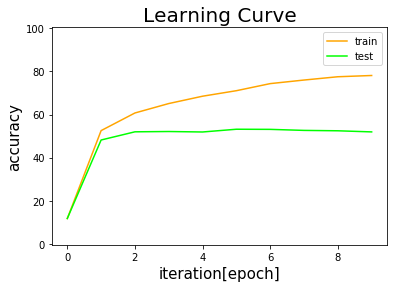

In [8]:
plt.figure(figsize=(6,4))

#plt.plot(np.array(past_train_accuracy), color='r')
plt.plot(past_train_accuracy, color='orange', label='train')
plt.plot(past_test_accuracy, color='lime', label='test')
plt.ylabel("accuracy", fontsize=15)
print("last train accuracy is {}".format(past_train_accuracy[-1]))
print("last test accuracy is {}".format(past_test_accuracy[-1]))
plt.ylim(-0.5, 100.5)


plt.legend()
plt.title('Learning Curve', fontsize=20)
plt.xlabel("iteration[epoch]", fontsize=15)